In this lab, we will investigate two highly useful features for image analysis: SIFT and Bag-of-words. 
Both of these features are widely used in computer vision and image analysis problems of all kinds, such as face recognition, similar image search, image classification, and object detection.

## Notes on OpenCV

The quickest way to install OpenCV, I have found in the past week, is to use Anaconda. You can either:
- Use the Anaconda Navigator. Go to the environment you use for your lab. Install opencv in this environment. Re-start your jupyter notebook
- Open the Anaconda Shell. Install opencv by using `conda install opencv`. Re-start your jupyter notebook.

Due to certain legal restrictions, current updated packages in OpenCV no longer have SIFT builtin. However, install opencv using the above commands have worked for me. 
Depending on the OS you are using there might be different instructions on how to build and install OpenCV with Python on SIFT. We will be using OpenCV 3.4.2 for this lab. Older versions should work as well, but you might have to change some lines of code. 

If you chose to build OpenCV from source, this will take a while. After the build process completes, a `cv2.so` will be produced in the lib folder. Copy this file to your notebook directory, this will allow you to do `import cv2`. **DO NOT SUBMIT THIS FILE**

**Make sure to at least get OpenCV and SIFT working before you leave the lab today.**

Documentation of OpenCV can be found [here](http://docs.opencv.org)

Some tutorials to serve as a guide:

https://towardsdatascience.com/bag-of-visual-words-in-a-nutshell-9ceea97ce0fb

https://kushalvyas.github.io/BOV.html


In [3]:
%matplotlib inline

## <span style="color:blue"> Tasks in this lab </span>
- Install and run OpenCV + SIFT
- Extract SIFT keypoints and SIFT descriptors
    - Match two images you have taken in the two different environments
- Cluster all descriptors to get the cluster centroids
- For each image in the dataset, generate the bag-of-words histogram based on these centroids
- Identify 5 closest images in the dataset.
    - Two own images
    - Two given images (bird.jpg, tree.jpg)
- (EXTRA) Generate a classifier to predict the label of the image

**There are 6 exercises and 1 extra credit exercise in this lab.** 

Instructions are given in the TODO pointers. 
**Start early as you will write most of the code in this lab by yourself.**

For this lab, you will need to download the Caltech-101 dataset (http://www.vision.caltech.edu/Image_Datasets/Caltech101/). This dataset contains 101 different object categories, each with between 40 to 800 images of size 300 x 200, roughly. (This dataset pales in comparison to other modern, "big data" image datasets, but it's the best that your computer can likely handle easily.) You should download and unzip this dataset to the same directory as your notebook. It should be in a folder called '101_ObjectCategories.'

### Necessary packages
- opencv (with the extended version which has SIFT)
- matplotlib
- numpy
- sklearn

### Load necessary libraries

In [4]:
import cv2
import lab5
import matplotlib.pyplot as plt
from scipy import misc
import numpy as np
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

# Scale Invariant Feature Transform (SIFT)

We will use OpenCV's built-in function to perform SIFT. In this part, we will find and match the keypoints of two images. One application is recognizing the traffic sign using the camera. You can watch a demo [here](http://bit.ly/1l51Tra). Let's first load the image and visualize the keypoints.

Documentation can be found [here](http://docs.opencv.org/3.1.0/da/df5/tutorial_py_sift_intro.html#gsc.tab=0)

In [5]:
cv2.__version__

'3.4.2'

### Example use of the SIFT keypoint detection and feature extraction
**Make sure you can run this first**

- We first read in an image 'box.png'
- We convert it to grayscale, because SIFT works with grayscale images
- Use the function `xfeatures2d.SIFT_create()` of cv2 to create a sift_object. (You might have to use `cv2.SIFT()` if you are using versions before 3.0.0)

In [6]:
import cv2
import numpy as np

boxImage1 = cv2.imread('box.png')
grayImage1= cv2.cvtColor(boxImage1,cv2.COLOR_BGR2GRAY)

#sift = cv2.SIFT() #use this for versions 3.0.0 and below
sift = cv2.xfeatures2d.SIFT_create() #Use this for versions >= 3.1.0

### <span style="color:blue"> Exercise 1(a) : SIFT on first image </span> 
TODO: 
- Use the `detect()` function of the sift_object to get the resulting keypoints `kp`
- Overlay and display the original image and the detected keypoints `kp` using the `drawKeypoints()` function of cv2 (and general matplotlib functions)

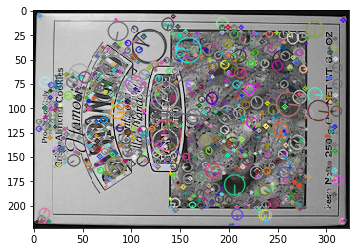

In [7]:
kp = sift.detect(grayImage1)
img = cv2.drawKeypoints(grayImage1, kp, boxImage1)
img=cv2.drawKeypoints(grayImage1,kp,boxImage1,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imwrite('box.png',img)
plt.imshow(img)

### <span style="color:blue"> Exercise 1(b) : SIFT on second image </span> 
TODO:
- Now, load and detect the keypoints, and show the overlay for the second image 'box_in_scene.png'.

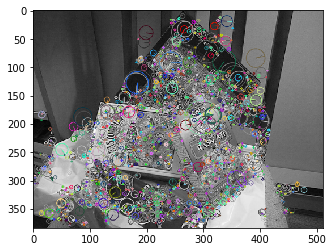

In [8]:
boxImage2 = cv2.imread('box_in_scene.png')
grayImage2 = cv2.cvtColor(boxImage2,cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create() #Use this for versions >= 3.1.0kp = sift.detect(grayImage2,None)
kp = sift.detect(grayImage2)
img = cv2.drawKeypoints(grayImage2, kp, boxImage1)
img=cv2.drawKeypoints(grayImage2,kp,boxImage2,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imwrite('box_in_scene.png',img)
plt.imshow(img)

## <span style="color:blue"> Exercise 2: Matching the Keypoints </span> 

We can use the detected SIFT keypoints to match the two images. For this, we need the keypoints as well as the SIFT descriptors for each keypoint. 
To search for matching keypoints, we will use the Brute Force Matcher, which tries to evaluate every possible match.

TODO: Computing the Matches:
- Use the function `detectAndCompute()` with `None` as the mask argument
- Generate keypoints and descriptors for both the box images
- Define the brute force matcher `BFMatcher()` from cv2 
- Use the `match()` function of the BFmatcher object to match the descriptors of the two images
- You might have to convert the descriptors to numpy arrays of float32 values 

TODO: Visualizing the Matches
- Once we have the matches, sort increasingly the matches based on the distance associated with each element in matches 
- Use the `drawMatches` function of cv2 to visualize the top 100 matches. You should have the two images side by side, with the circled keypoints matched by colored lines

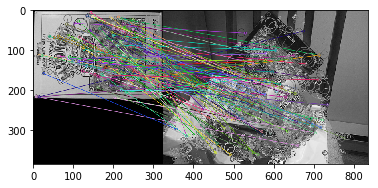

(<matplotlib.image.AxesImage at 0x213a9a1ff98>, None)

In [9]:
kp1, des1 = sift.detectAndCompute(grayImage1,None)
kp2, des2 = sift.detectAndCompute(grayImage2,None)
bf = cv2.BFMatcher()
matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)
img3 = cv2.drawMatches(grayImage1,kp1,grayImage2,kp2,matches[:100], None, flags=2)
plt.imshow(img3),plt.show()


### <span style="color:blue"> Exercise 3(a): Matching the Keypoints on your images </span> 

TODO:
- Repeat the steps in Exercise 2 with the two images you have taken (indoors and outdoors)
- Show the matches obtained (as above)

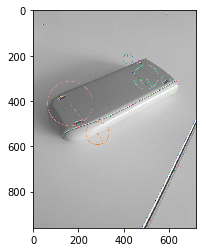

In [10]:
indoor = cv2.imread('indoor.jpg')
indoorgray = cv2.cvtColor(indoor,cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(indoorgray)
img = cv2.drawKeypoints(indoorgray, kp, indoor)
img=cv2.drawKeypoints(indoorgray,kp,indoor,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imwrite('indoorgray.jpg',img)
plt.imshow(img)

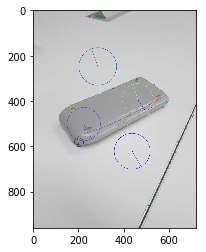

In [11]:
outdoor = cv2.imread('outdoor.jpg')
outdoorgray = cv2.cvtColor(outdoor,cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(outdoorgray)
img = cv2.drawKeypoints(outdoorgray, kp, outdoor)
img=cv2.drawKeypoints(outdoorgray,kp,outdoor,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imwrite('outdoorgray.jpg',img)
plt.imshow(img)

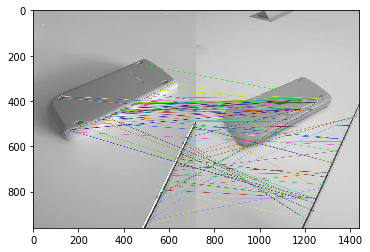

(<matplotlib.image.AxesImage at 0x213a9d1f668>, None)

In [12]:
kp1, des1 = sift.detectAndCompute(indoorgray,None)
kp2, des2 = sift.detectAndCompute(outdoorgray,None)
bf = cv2.BFMatcher()
matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)
img3 = cv2.drawMatches(indoorgray,kp1,outdoorgray,kp2,matches[:100], None, flags=2)
plt.imshow(img3),plt.show()


TODO:
1. Was SIFT able to match your two images correctly? Is SIFT robust to lighting differences in your images?
2. In the matching code above, BFMatcher was used to find matching pairs. Suggest an improvement that might be able to decrease the run time of this step.

Your answer: Yes it matches correctly. It does robust to lighting differences. Using a hashtable will make it faster


### <span style="color:blue"> Exercise 3(b): Matching the Keypoints on images from Caltech101 </span> 

Choose any 3 images each from 2 different classes in the Caltech 101 dataset. Compute SIFT features and try to match them. Some images will match well while others will not. Briefly explain why this is so. Support your answer with some code.


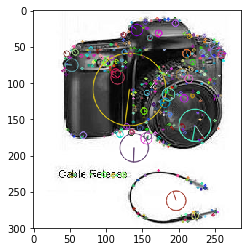

In [14]:
img1 = cv2.imread('image_0001.jpg')
grayimg1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create() #Use this for versions >= 3.1.0kp = sift.detect(grayImage2,None)
kp = sift.detect(grayimg1)
img = cv2.drawKeypoints(grayimg1, kp, img1)
img=cv2.drawKeypoints(grayimg1,kp,img1,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imwrite('gray_0001.jpg',img)
plt.imshow(img)

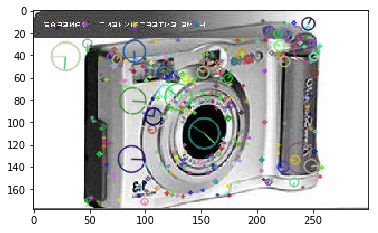

In [15]:
img2 = cv2.imread('image_0002.jpg')
grayimg2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create() #Use this for versions >= 3.1.0kp = sift.detect(grayImage2,None)
kp = sift.detect(grayimg2)
img = cv2.drawKeypoints(grayimg2, kp, img2)
img=cv2.drawKeypoints(grayimg2,kp,img2,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imwrite('gray_0002.jpg',img)
plt.imshow(img)

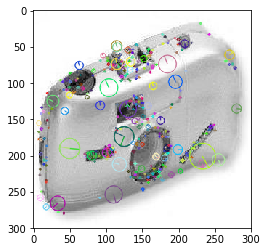

In [16]:
img3 = cv2.imread('image_0003.jpg')
grayimg3 = cv2.cvtColor(img3,cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create() #Use this for versions >= 3.1.0kp = sift.detect(grayImage2,None)
kp = sift.detect(grayimg3)
img = cv2.drawKeypoints(grayimg3, kp, img3)
img=cv2.drawKeypoints(grayimg3,kp,img3,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imwrite('gray_0003.jpg',img)
plt.imshow(img)

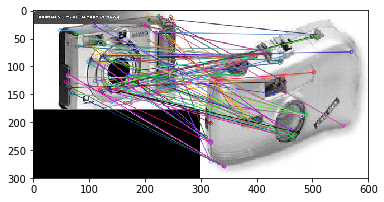

(<matplotlib.image.AxesImage at 0x213aa731b00>, None)

In [17]:
kp1, des1 = sift.detectAndCompute(grayimg2,None)
kp2, des2 = sift.detectAndCompute(grayimg3,None)
bf = cv2.BFMatcher()
matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)
img3 = cv2.drawMatches(grayimg2,kp1,grayimg3,kp2,matches[:100], None, flags=2)
plt.imshow(img3),plt.show()


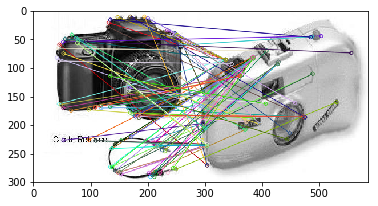

(<matplotlib.image.AxesImage at 0x213aa7917b8>, None)

In [18]:
kp1, des1 = sift.detectAndCompute(grayimg1,None)
kp2, des2 = sift.detectAndCompute(grayimg3,None)
bf = cv2.BFMatcher()
matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)
img3 = cv2.drawMatches(grayimg1,kp1,grayimg3,kp2,matches[:100], None, flags=2)
plt.imshow(img3),plt.show()

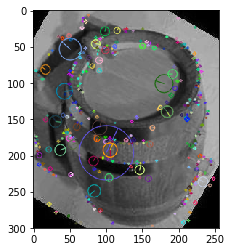

In [19]:
img4 = cv2.imread('image_0004.jpg')
grayimg4 = cv2.cvtColor(img4,cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create() #Use this for versions >= 3.1.0kp = sift.detect(grayImage2,None)
kp = sift.detect(grayimg4)
img = cv2.drawKeypoints(grayimg4, kp, img4)
img=cv2.drawKeypoints(grayimg4,kp,img4,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imwrite('gray_0004.jpg',img)
plt.imshow(img)

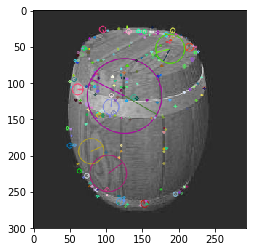

In [20]:
img5 = cv2.imread('image_0005.jpg')
grayimg5 = cv2.cvtColor(img5,cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create() #Use this for versions >= 3.1.0kp = sift.detect(grayImage2,None)
kp = sift.detect(grayimg5)
img = cv2.drawKeypoints(grayimg5, kp, img5)
img=cv2.drawKeypoints(grayimg5,kp,img5,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imwrite('gray_0005.jpg',img)
plt.imshow(img)

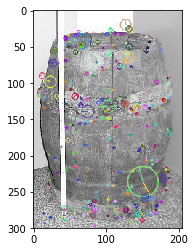

In [21]:
img6 = cv2.imread('image_0006.jpg')
grayimg6 = cv2.cvtColor(img6,cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create() #Use this for versions >= 3.1.0kp = sift.detect(grayImage2,None)
kp = sift.detect(grayimg6)
img = cv2.drawKeypoints(grayimg6, kp, img6)
img=cv2.drawKeypoints(grayimg6,kp,img6,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imwrite('gray_0006.jpg',img)
plt.imshow(img)

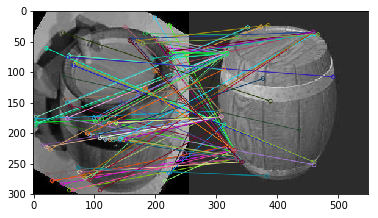

(<matplotlib.image.AxesImage at 0x213aa8f04a8>, None)

In [22]:
kp1, des1 = sift.detectAndCompute(grayimg4,None)
kp2, des2 = sift.detectAndCompute(grayimg5,None)
bf = cv2.BFMatcher()
matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)
img3 = cv2.drawMatches(grayimg4,kp1,grayimg5,kp2,matches[:100], None, flags=2)
plt.imshow(img3),plt.show()

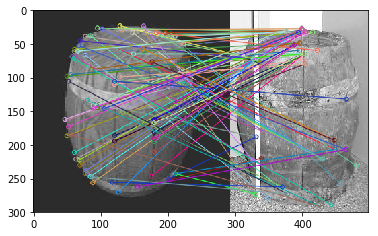

(<matplotlib.image.AxesImage at 0x213aa94f208>, None)

In [23]:
kp1, des1 = sift.detectAndCompute(grayimg5,None)
kp2, des2 = sift.detectAndCompute(grayimg6,None)
bf = cv2.BFMatcher()
matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)
img3 = cv2.drawMatches(grayimg5,kp1,grayimg6,kp2,matches[:100], None, flags=2)
plt.imshow(img3),plt.show()

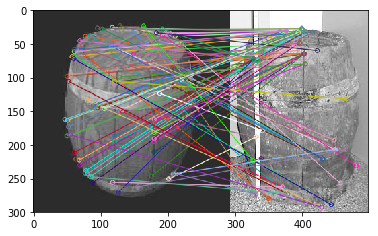

(<matplotlib.image.AxesImage at 0x21428d86fd0>, None)

In [42]:
kp1, des1 = sift.detectAndCompute(grayimg5,None)
kp2, des2 = sift.detectAndCompute(grayimg6,None)
bf = cv2.BFMatcher()
matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)
img3 = cv2.drawMatches(grayimg5,kp1,grayimg6,kp2,matches[:100], None, flags=2)
plt.imshow(img3),plt.show()

Some images such as camera 2 and 3 matches well since they have same background and camera color in grayscale while others do not. 

Pause.
We now have a mechanism of generating SIFT descriptors for each image. We will now implement the Bag-of-words model using SIFT features.

### First, load the data for our next tasks

In [25]:
dataset_dir = '101_ObjectCategories/'

n_images, classes, image_names = lab5.load_image_dataset(dataset_dir)
print(n_images)

for c in classes[:105]:
    print(c)

9144
accordion
airplanes
anchor
ant
BACKGROUND_Google
barrel
bass
beaver
binocular
bonsai
brain
brontosaurus
buddha
butterfly
camera
cannon
car_side
ceiling_fan
cellphone
chair
chandelier
cougar_body
cougar_face
crab
crayfish
crocodile
crocodile_head
cup
dalmatian
dollar_bill
dolphin
dragonfly
electric_guitar
elephant
emu
euphonium
ewer
Faces
Faces_easy
ferry
flamingo
flamingo_head
garfield
gerenuk
gramophone
grand_piano
hawksbill
headphone
hedgehog
helicopter
ibis
inline_skate
joshua_tree
kangaroo
ketch
lamp
laptop
Leopards
llama
lobster
lotus
mandolin
mayfly
menorah
metronome
minaret
Motorbikes
nautilus
octopus
okapi
pagoda
panda
pigeon
pizza
platypus
pyramid
revolver
rhino
rooster
saxophone
schooner
scissors
scorpion
sea_horse
snoopy
soccer_ball
stapler
starfish
stegosaurus
stop_sign
strawberry
sunflower
tick
trilobite
umbrella
watch
water_lilly
wheelchair
wild_cat
windsor_chair
wrench
yin_yang


### <span style="color:blue"> Exercise 4: Get Descriptors for All Images </span> 
For all images corresponding to `image_names` above
- run the SIFT key-point detector and descriptor
- if the descriptor is non-empty, append the `descriptor`, `image_name` and `image_label` to lists `descriptors`, `names` and `labels` respectively
- labels can be obtained by using `name.split('\\')[1]` or something equivalent, depending on your OS

This block can take about 10-15 minutes.

In [26]:
import numpy as np

In [27]:
descriptors = []
name = []
labels = []


In [28]:
sift = cv2.xfeatures2d.SIFT_create()

for img_name in image_names:
    img = cv2.imread(img_name)
    grayimg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    kp1, des1 = sift.detectAndCompute(grayimg, None)
    if des1 is not None:
        descriptors.append(des1)
        name.append(img_name)
        labels.append(img_name.split('\\')[1])

### <span style="color:blue"> Exercise 5: Clustering the Descriptors</span> 
Once we have the descriptors for all the images in our data set, we will first cluster them using the K-Means algorithm to get important cluster centroids. These will serve as representative descriptors. We will then map each descriptor of each image to the closest descriptor centroid, and build a histogram of these for each image. This is the idea behind the Bag-of-words feature discussed in class last week.

Thus, for each image, the histogram of closest centroids will be the feature vector representation.

#### <span style="color:blue"> Exercise 5(a): Obtaining the centroids</span> 
TODO
- Combine all descriptors into one big list `all_decs`. You can use for loops or neater Python tricks.
- Convert `all_decs` to an np array 
- Run `MiniBatch_KMeans` or `KMeeans` with all the descriptors with K=100 to get 100 dominant clusters of descriptors. 
- Remember to call `fit()` using the array `all_decs`

In [29]:
all_dec = []
for a in range (0,len(descriptors)):
    for b in range (0,descriptors[a].shape[0]):
        all_dec.append(descriptors[a][b])

In [30]:
all_decs = np.array(all_dec)

In [31]:
output = MiniBatchKMeans(n_clusters = 100).fit(all_decs)

#### <span style="color:blue"> Exercise 5(b): Clustering</span> 
Now, we have the KMeans model trained for the descriptors. We can now, obtain the histogram descriptors for the Bag-of-words model.

TODO: For each image, 
- Predict the closest cluster for all descriptors of the image using the KMeans trained above
- Generate a histogram with number_of_bins = number_of_clusters = 100
- Normalize the histogram by the number of descriptors for the image

Save all these histograms in a list `all_hists`, and then convert `all_hists` to an array: it should be of size `(9143, 100)`.

In [32]:
all_hist = []

for a in range (len(descriptors)):
    data = output.predict(descriptors[a])
    hist = np.histogram(data, bins=100, normed= True)
    all_hist.append(hist[0])
    

In [33]:
all_hists = np.array(all_hist)
print(all_hists.shape)

(9143, 100)


### <span style="color:blue"> Exercise 6: Most Similar Images</span> 

You now have features for all images in the dataset! Now, you can query the dataset and find the images most similar in the dataset to any image you have. Do this for
1. Your two images (indoors and outdoors) 
2. bird.jpg
3. tree.jpg 

#### <span style="color:blue"> Exercise 6(a): Get the feature for the query image</span> 
You will follow the same steps as you did for the dataset above, to get the feature descriptor. Of course, you will not train your KMeans algorithm. You will just use it for prediction.

TODO:  
- Read in a query image 
- Convert to grayscale
- Compute SIFT keypoints and descriptors
- Obtain the closest cluster centroid of each descriptor using the KMeans model
- Generate a histogram of these values (as you did above)

For a sanity check, plot all the histograms in your dataset, and your query histogram (in a different color) on a matplotlib plot. Include this plot in your submission.

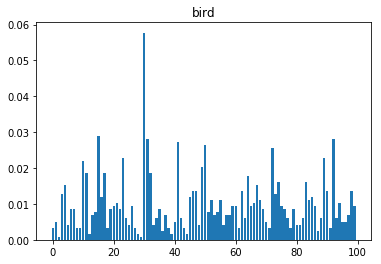

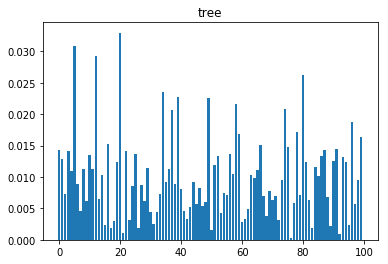

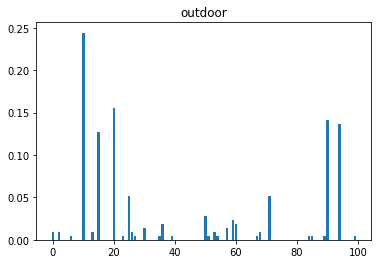

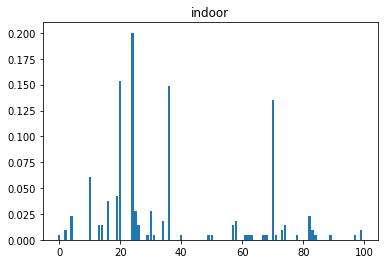

In [34]:
hist1 = []
boxImage1 = cv2.imread('bird.jpg')
grayImage1 = cv2.cvtColor(boxImage1, cv2.COLOR_BGR2GRAY)
kp1, des1 = sift.detectAndCompute(grayImage1, None)
pred = output.predict(des1)
hist = np.histogram(pred, normed = True, bins = 100)
hist1.append(hist[0])
y=hist[0]
x=np.arange(0, 100)
plt.title("bird")
plt.bar(x=x, height=y)
plt.show()

hist2 = []
boxImage2 = cv2.imread('tree.jpg')
grayImage2 = cv2.cvtColor(boxImage2, cv2.COLOR_BGR2GRAY)
kp1, des1 = sift.detectAndCompute(grayImage2, None)
pred = output.predict(des1)
hist = np.histogram(pred, normed = True, bins = 100)
hist2.append(hist[0])
y=hist[0]
x=np.arange(0, 100)
plt.title("tree")
plt.bar(x=x, height=y)
plt.show()

hist3 = []
boxImage2 = cv2.imread('outdoor.jpg')
grayImage2 = cv2.cvtColor(boxImage2, cv2.COLOR_BGR2GRAY)
kp1, des1 = sift.detectAndCompute(grayImage2, None)
pred = output.predict(des1)
hist = np.histogram(pred, normed = True, bins = 100)
hist3.append(hist[0])
y=hist[0]
x=np.arange(0, 100)
plt.title("outdoor")
plt.bar(x=x, height=y)
plt.show()

hist4 = []
boxImage2 = cv2.imread('indoor.jpg')
grayImage2 = cv2.cvtColor(boxImage2, cv2.COLOR_BGR2GRAY)
kp1, des1 = sift.detectAndCompute(grayImage2, None)
pred = output.predict(des1)
hist = np.histogram(pred, normed = True, bins = 100)
hist4.append(hist[0])
y=hist[0]
x=np.arange(0, 100)
plt.title("indoor")
plt.bar(x=x, height=y)
plt.show()

#### <span style="color:blue"> Exercise 6(b): Obtain the closest images </span> 

TODO: 
- Use the `expand_dims` function of numpy to generate a dummy first axis. Your query image's feature should now be of size `(1, 128)`
- Compute the L1 or manhattan distance between your query histogram and all the histograms of your dataset. You can use the imported function `manhattan_distances()`
- Sort the resulting distances (using `argsort` from numpy)
- Display the images and print the labels of the 5 closest images in your dataset. Also show your original query image for reference.

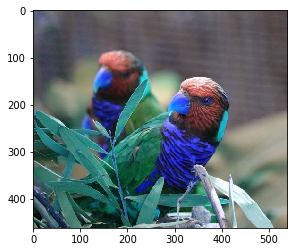

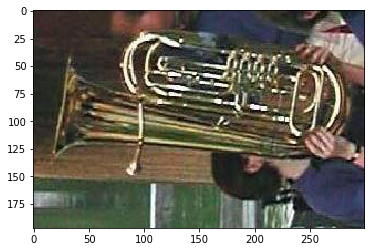

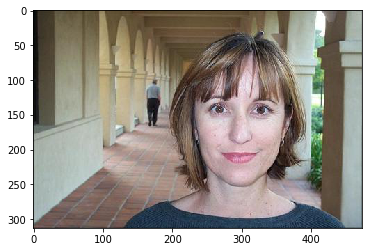

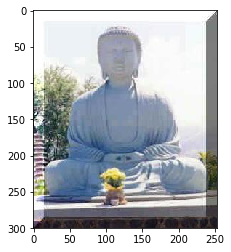

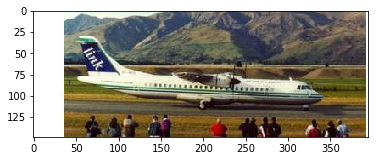

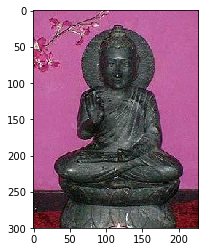

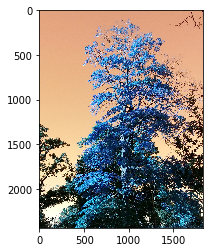

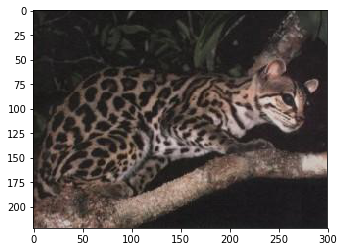

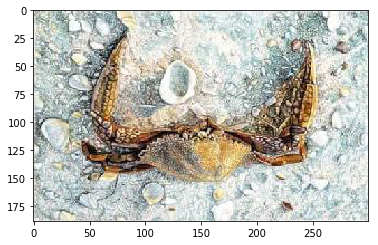

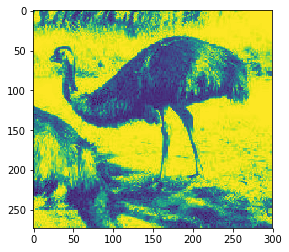

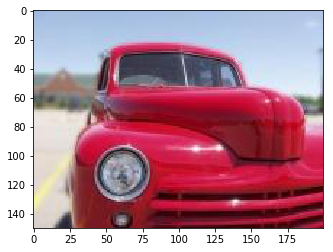

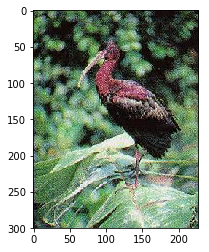

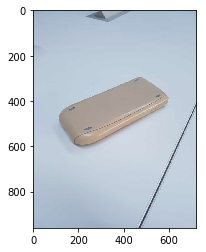

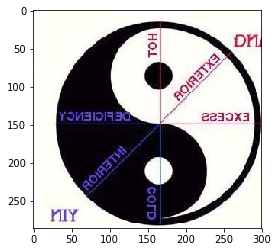

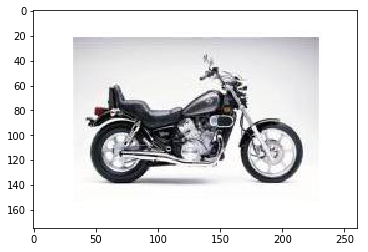

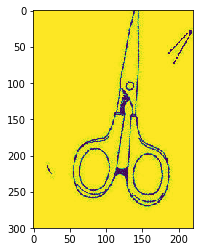

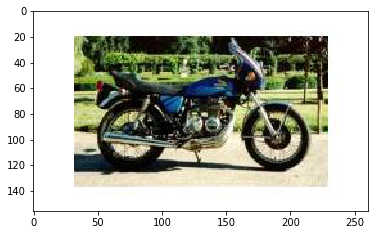

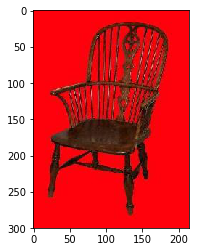

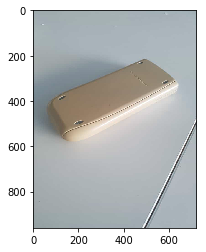

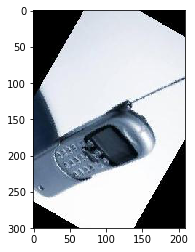

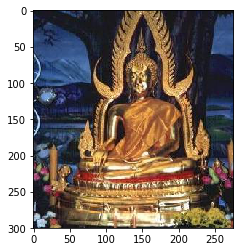

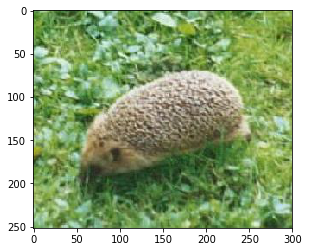

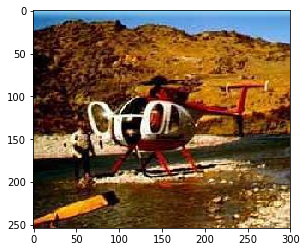

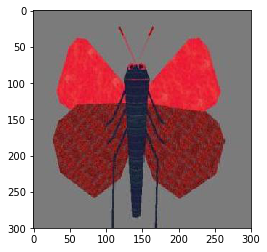

In [43]:
boxImage1 = cv2.imread('bird.jpg')
plt.imshow(boxImage1)
plt.show()
feature = np.expand_dims(hist1[0], axis = 0)
feature = np.asarray(feature)
man = manhattan_distances(all_hists, feature)
man = man.ravel()
sort = np.argsort(man)
for i in range(5):
    temp = plt.imread(image_names[sort[i]])
    plt.imshow(temp)
    plt.show()
    
boxImage2 = cv2.imread('tree.jpg')
plt.imshow(boxImage2)
plt.show()
feature = np.expand_dims(hist2[0], axis = 0)
feature = np.asarray(feature)
man = manhattan_distances(all_hists, feature)
man = man.ravel()
sort = np.argsort(man)
for i in range(5):
    temp = plt.imread(image_names[sort[i]])
    plt.imshow(temp)
    plt.show()
    
boxImage2 = cv2.imread('outdoor.jpg')
plt.imshow(boxImage2)
plt.show()
feature = np.expand_dims(hist3[0], axis = 0)
feature = np.asarray(feature)
man = manhattan_distances(all_hists, feature)
man = man.ravel()
sort = np.argsort(man)
for i in range(5):
    temp = plt.imread(image_names[sort[i]])
    plt.imshow(temp)
    plt.show()
    
boxImage2 = cv2.imread('indoor.jpg')
plt.imshow(boxImage2)
plt.show()
feature = np.expand_dims(hist4[0], axis = 0)
feature = np.asarray(feature)
man = manhattan_distances(all_hists, feature)
man = man.ravel()
sort = np.argsort(man)
for i in range(5):
    temp = plt.imread(image_names[sort[i]])
    plt.imshow(temp)
    plt.show()

TODO:
1. Was SIFT-BOW able to retrieve similar images for your two images? 
2. Do the images returned for `bird.jpg` and `tree.jpg` make sense?

Your answer: <br>
1. They catch the edge of my object. <Br>
2. For both bird and tree they get similar images

### <span style="color:purple"> Extra Exercise 7: Classification </span> 

TODO:
- Use a label-encoder to encode all the classes(labels) in your data
- Shuffle your data, and generate 70-30 splits (X=histograms, y=labels)
- Use your favourite classifier and train to predict the class of image using the histogram
- Report your accuracy, precision, recall and confusion matrix for both training and testing data
- What does your classifier predict for the 4 images from the previous exercise?

Feel free to use `sklearn`